In [48]:
# from google.colab import drive
# drive.mount('/content/drive')

In [49]:
# ! pip install pgmpy

In [50]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [51]:
import pandas as pd
import numpy as np

import common

In [52]:
data_set_path = "../temp_sets_100/"

# admissions

## Data Process

### Read samples

In [53]:
admissions_df = common.read_csv_no_rowid(date_set_path+"admissions.csv")

In [54]:
dob_df = pd.read_csv(date_set_path+"patients.csv").loc[:, ['subject_id', 'dob']]

In [55]:
# patients_df = pd.read_csv(date_set_path+"patients.csv")
# dob_df = patients_df.loc[:, ['subject_id', 'dob']]

### Data preproces

In [56]:
# Drop useless colums
admissions_df.drop(['diagnosis', 'hospital_expire_flag'], axis=1, inplace=True)

In [57]:
admissions_df = pd.merge(dob_df, admissions_df, how='inner', on='subject_id')

#### Deal with missing values

In [58]:
# Check null value in table
common.nan_count(admissions_df)

Total columns: 17
Total rows: 143
--------------
subject_id                0
dob                       0
hadm_id                   0
admittime                 0
dischtime                 0
deathtime               129
admission_type            0
admission_location        0
discharge_location        0
insurance                 0
language                 63
religion                  1
marital_status           21
ethnicity                 0
edregtime                66
edouttime                66
has_chartevents_data      0
dtype: int64


In [59]:
# Set a value replacing the null time value
# nan_datetime=pd.to_datetime(0)

In [60]:
# admissions_df['dob'].fillna(value=nan_datetime, inplace=True)
# admissions_df['dod_hosp'].fillna(value=nan_datetime, inplace=True)
# admissions_df['dod_ssn'].fillna(value=nan_datetime, inplace=True)

In [61]:
common.nan_count(admissions_df)

Total columns: 17
Total rows: 143
--------------
subject_id                0
dob                       0
hadm_id                   0
admittime                 0
dischtime                 0
deathtime               129
admission_type            0
admission_location        0
discharge_location        0
insurance                 0
language                 63
religion                  1
marital_status           21
ethnicity                 0
edregtime                66
edouttime                66
has_chartevents_data      0
dtype: int64


#### Set the column types

In [62]:
admissions_df.dtypes

subject_id               int64
dob                     object
hadm_id                  int64
admittime               object
dischtime               object
deathtime               object
admission_type          object
admission_location      object
discharge_location      object
insurance               object
language                object
religion                object
marital_status          object
ethnicity               object
edregtime               object
edouttime               object
has_chartevents_data     int64
dtype: object

In [63]:
# Transfer some date type
admissions_df['admittime'] = pd.to_datetime(admissions_df['admittime'])
admissions_df['dischtime'] = pd.to_datetime(admissions_df['dischtime'])
admissions_df['deathtime'] = pd.to_datetime(admissions_df['deathtime'])
admissions_df['edregtime'] = pd.to_datetime(admissions_df['edregtime'])
admissions_df['edouttime'] = pd.to_datetime(admissions_df['edouttime'])

admissions_df['dob'] = pd.to_datetime(admissions_df['dob'])

In [64]:
(admissions_df['dob'] < admissions_df['admittime']).value_counts()

True    143
dtype: int64

In [65]:
admissions_df.dtypes

subject_id                       int64
dob                     datetime64[ns]
hadm_id                          int64
admittime               datetime64[ns]
dischtime               datetime64[ns]
deathtime               datetime64[ns]
admission_type                  object
admission_location              object
discharge_location              object
insurance                       object
language                        object
religion                        object
marital_status                  object
ethnicity                       object
edregtime               datetime64[ns]
edouttime               datetime64[ns]
has_chartevents_data             int64
dtype: object

#### Process some special value

`dischtime` should be equals to `deathtime` (if `deathtime` is exist), so we drop the row where `dischtime` != `deathtime`

In [66]:
# admissions_df.loc[113]

In [67]:
# admissions_df = admissions_df.drop(admissions_df.loc[(pd.isna(admissions_df['deathtime']) == False) & (admissions_df['dischtime'] != admissions_df['deathtime'])].index)

#### Process time data

In [68]:
import datetime
import random

def adjust_age_over_90(df):
    '''
    This method is to adjust the invalid date in 'dob' (which is 18xx)
    Process: Use the admittime minus 90 - 100 years, to let the age of patients are between 90 to 100
    '''

    years_100 = datetime.timedelta(days = (365 * 100 + 100/4))
    random_days_10_years = datetime.timedelta(days = random.randint(0, 10)*365)
    
    if (df['dob'] - datetime.datetime(1970,1,1)).total_seconds() < 0:
        return (df['admittime'] - years_100 + random_days_10_years)
    else:
        return df['dob']

In [69]:
admissions_df['dob'] = admissions_df.apply(adjust_age_over_90, axis=1)

For `deathtime`, If `deathtime` exist, it should euqal to `dischtime`, so I set `deathtime` = 1 if it exist. In sythetic data, set `deathtime` = `dischtime` if it is 1.

For others time data, I save the time difference as the columns. In sythetic data, I just need to use the time difference to calculate the exact time.

In [70]:
admissions_df['deathtime'] = admissions_df['deathtime'].apply(lambda flag: 1 if pd.isna(flag) == False else np.NaN)

In [71]:
# def time_process(df, early_col_name, late_col_name):
#     '''
#     If 2 columns both exist, then use late_col - early_col, and save the difference as late_col
#     '''

#     if (pd.isna(df[early_col_name]) == False) & (pd.isna(df[late_col_name]) == False):
#         # return abs(np.int64(df[late_col_name].to_numpy() - df[early_col_name].to_numpy())/10**9)
#         return abs(df[late_col_name] - df[early_col_name]).total_seconds()
#     else:
#         return np.NaN

In [72]:
admissions_df['edouttime'] = admissions_df.apply(common.time_process, args=('edregtime', 'edouttime'), axis=1)
admissions_df['edregtime'] = admissions_df.apply(common.time_process, args=('admittime', 'edregtime'), axis=1)
admissions_df['dischtime'] = admissions_df.apply(common.time_process, args=('admittime', 'dischtime'), axis=1)
admissions_df['admittime'] = admissions_df.apply(common.time_process, args=('dob', 'admittime'), axis=1)

In [73]:
admissions_df.drop(['subject_id', 'dob'], axis=1, inplace=True)

---

##  Build model

### Set constraints

In [76]:
def both_exist(column_names, data):
    exist = (pd.isna(data[column_names[0]]) == False) & (pd.isna(data[column_names[1]]) == False)
    not_exist = pd.isna(data[column_names[0]]) & pd.isna(data[column_names[1]])

    return  exist | not_exist

In [77]:
from sdv.constraints import create_custom_constraint

EdregEdoutTime = create_custom_constraint(
    is_valid_fn=both_exist,
)

edreg_edout_time_constraint = EdregEdoutTime(
    column_names=['edregtime', 'edouttime']
)

In [78]:
from sdv.constraints import Unique

unique_hadm_id_constraint = Unique(
    column_names=['hadm_id']
)

In [79]:
from sdv.constraints import Positive

admittime_positive = Positive(column_name='admittime')
dischtime_positive = Positive(column_name='dischtime')
edregtime_positive = Positive(column_name='edregtime')
edouttime_positive = Positive(column_name='edouttime')

In [80]:
constraints = [admittime_positive, dischtime_positive, edregtime_positive, edouttime_positive, unique_hadm_id_constraint, edreg_edout_time_constraint]

### Build model

In [81]:
train_data = admissions_df

In [82]:
best_model = common.build_model(constraints=constraints, train_data=train_data)

Strat training ...
Tabular Preset


Sampling rows: 100%|██████████| 143/143 [00:00<00:00, 1741.99it/s]

Gaussian Copula



Sampling rows: 100%|██████████| 143/143 [00:00<00:00, 4280.30it/s]


CTGAN


Sampling rows: 100%|██████████| 143/143 [00:00<00:00, 1131.59it/s]


CopulaGAN


Sampling rows: 100%|██████████| 143/143 [00:00<00:00, 586.20it/s]


TVAE


Sampling rows: 100%|██████████| 143/143 [00:00<00:00, 1235.74it/s]


Training finished!
Strat evaluating ...
Evaluating finished!
The best_model is tabular, evaluation score is 0.6571480939180836


In [84]:
model_save_path = data_set_path + "100_models/" + "admissions_model.pkl"
common.save_model(best_model, model_save_path)

---

## Evaluate data

### Generate synthetic data

In [88]:
date_load_path = data_set_path + "100_models/" + "admissions_model.pkl"
model = common.load_model(date_load_path)

In [89]:
sample = model.sample(num_rows=len(train_data))

Sampling rows: 100%|██████████| 143/143 [00:00<00:00, 2438.40it/s]


### Evaluation

In [90]:
from sdv.evaluation import evaluate

In [91]:
evaluate(sample, train_data, metrics=['ContinuousKLDivergence'])

0.6466802625802228

In [92]:
evaluate(sample, train_data, metrics=['DiscreteKLDivergence'])

0.4387762118066264

In [93]:
evaluate(sample, train_data)

0.6684363541329703

In [ ]:
sample['admission_type'].value_counts()

EMERGENCY    118
NEWBORN        4
ELECTIVE       1
Name: admission_type, dtype: int64

<AxesSubplot:>

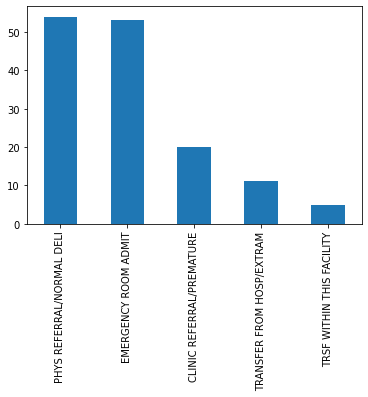

In [94]:
sample['admission_location'].value_counts().plot.bar()

In [95]:
train_data['admission_type'].value_counts()

EMERGENCY    110
NEWBORN       16
ELECTIVE      14
URGENT         3
Name: admission_type, dtype: int64

<AxesSubplot:>

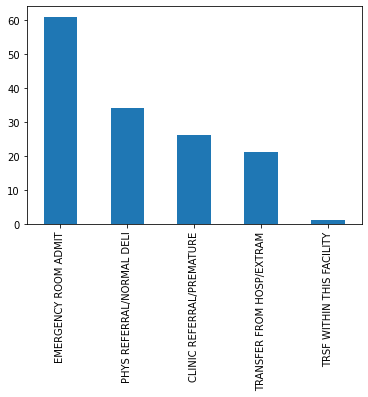

In [96]:
train_data['admission_location'].value_counts().plot.bar()

<AxesSubplot:xlabel='admission_type', ylabel='admission_location'>

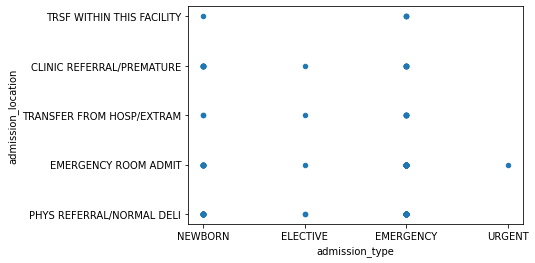

In [97]:
sample.plot.scatter(x='admission_type',y='admission_location')

<AxesSubplot:xlabel='admission_type', ylabel='admission_location'>

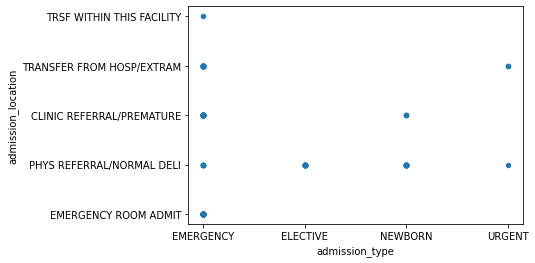

In [98]:
train_data.plot.scatter(x='admission_type',y='admission_location')

<AxesSubplot:>

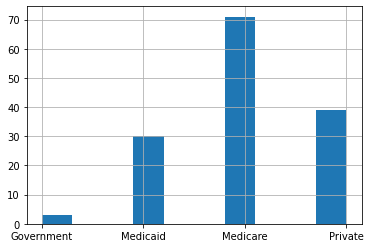

In [99]:
train_data.sort_values(by='insurance')['insurance'].hist()

<AxesSubplot:>

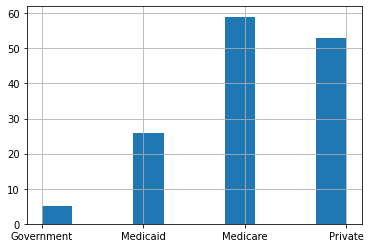

In [100]:
sample.sort_values(by='insurance')['insurance'].hist()